# Vehicle Tracking

## Feature Selection

In [1]:
# Develop training - test dataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import glob


project_path = "/home/james/Documents/CarND-VehicleDetection-P5/"
#project_path = "C:/Users/james/Desktop/CarND-P5-master/"

# Import Images:
vehicles_folder = glob.glob(project_path + "Dataset/vehicles/*")
non_vehicles_folder = glob.glob(project_path + "Dataset/non-vehicles/*")

Vehicles = []
NotVehicles = []

# Read all vehicles
for subfolder in vehicles_folder:
    images = glob.glob(subfolder + "/*.png")
    for image in images:
        Vehicles.append(cv2.imread(image)) # Read Image as BGR, 0 - 255.
        
# Read all non-vehicles
for subfolder in non_vehicles_folder:
    images = glob.glob(subfolder + "/*.png")
    for image in images:
        img = cv2.imread(image)# Read Image as BGR, 0 - 255.
        NotVehicles.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB) ) #  Save images as RGB

vehsize = len(Vehicles)
notvehsize = len(NotVehicles)
total = vehsize + notvehsize
print(str(len(Vehicles)) + " Vehicles Images Imported. "+ str(round(100*vehsize/(total),2)) + "%")
print(str(len(NotVehicles)) + " Non Vehicle Images Imported. "+ str(round(100*notvehsize/(total),2)) + "%")

9194 Vehicles Images Imported. 46.76%
10469 Non Vehicle Images Imported. 53.24%


In [2]:
# Define Helper Function to Convert Images, input must be RGB
def ConvertColorSpace(img,cspace):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)     
    else:
        feature_image = np.copy(img) 
    return feature_image

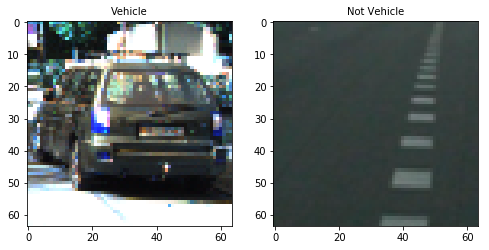

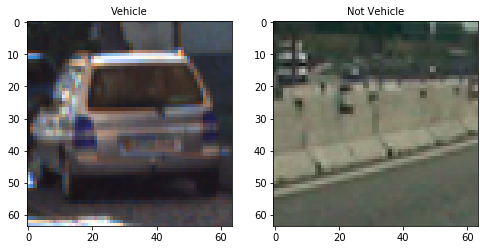

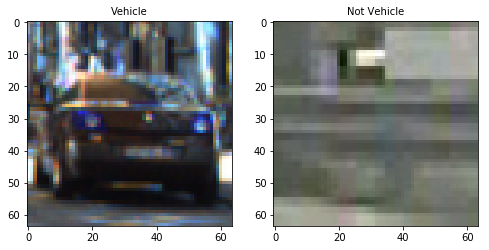

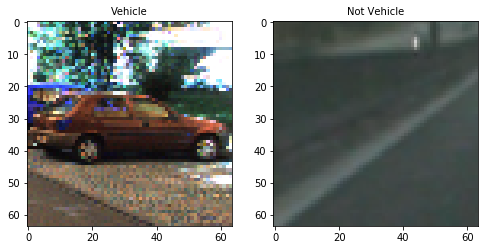

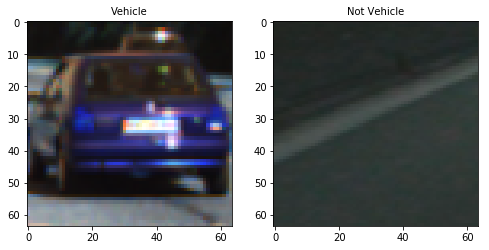

In [3]:
# Display some images
n=5
x = np.random.randint(0, vehsize-n)
images_vehicle= Vehicles [x: x+n]
images_nonvehicle = NotVehicles[x: x+n]

for i in range(n):
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(7, 7))
    f.tight_layout()
    ax1.imshow(images_vehicle[i])
    ax1.set_title('Vehicle', fontsize=10)
    ax2.imshow(images_nonvehicle[i])
    ax2.set_title('Not Vehicle', fontsize=10)



### Color histogram

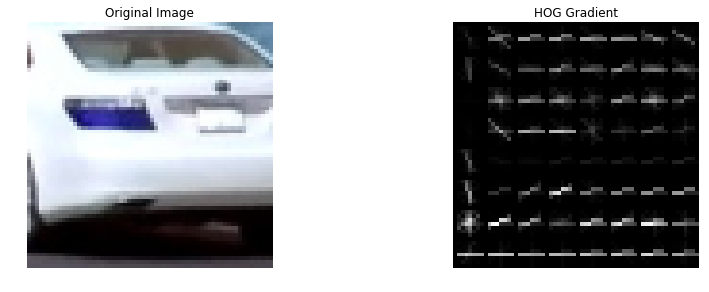

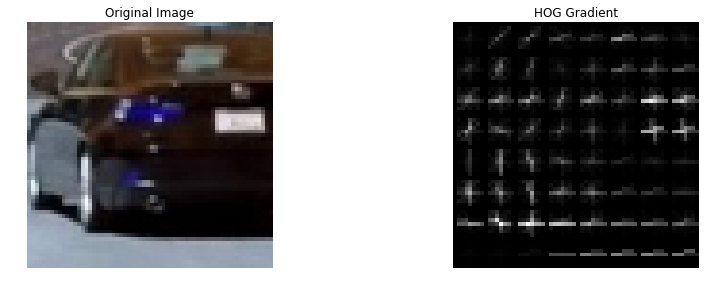

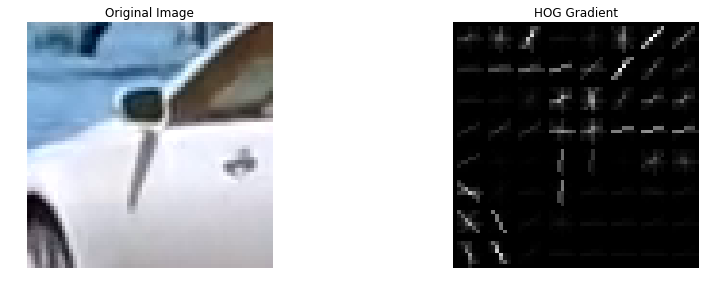

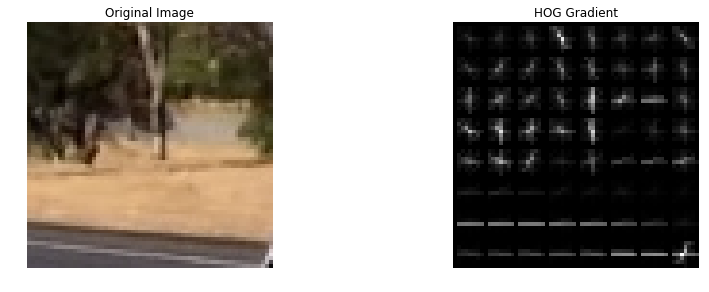

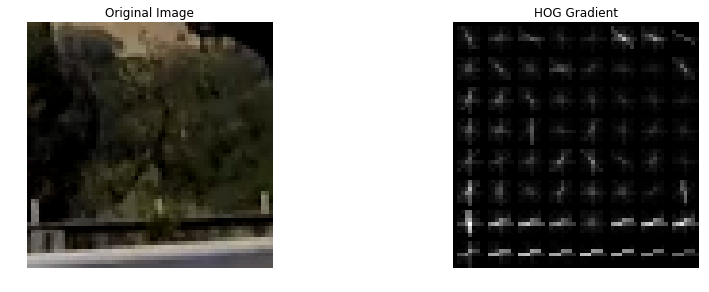

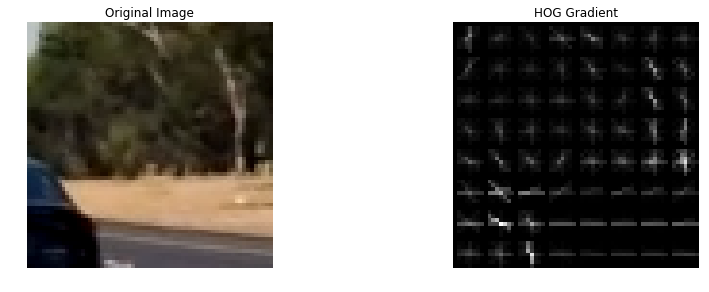

In [4]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis, feature_vec):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)        
        return features
    
# DEVELOPMENT AND VISUALIZATION OF HOG Feature Extraction:

#HOG Parameters for development:
cspace_HOG_d = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient_d  = 12
pix_per_cell_d  = 8
cell_per_block_d  = 2
hog_channel_d  = 0 

# Get random n vehicle images
n=3
x = np.random.randint(0, vehsize-n)
images_car= Vehicles [x: x+ n]
images_nocar = NotVehicles[x: x+n]
images_list = images_car + images_nocar

# Run HOG and compare outputs:
for img in images_list:
    feature_image =  ConvertColorSpace(img,cspace_HOG_d)   
    
    
    
    f_vec, image_hog = get_hog_features(feature_image[:,:,hog_channel_d], orient_d,
                                        pix_per_cell_d, cell_per_block_d,True,True)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image' )
    ax1.axis('off')
    ax2.imshow(image_hog,cmap = 'gray')
    ax2.set_title('HOG Gradient')
    ax2.axis('off')

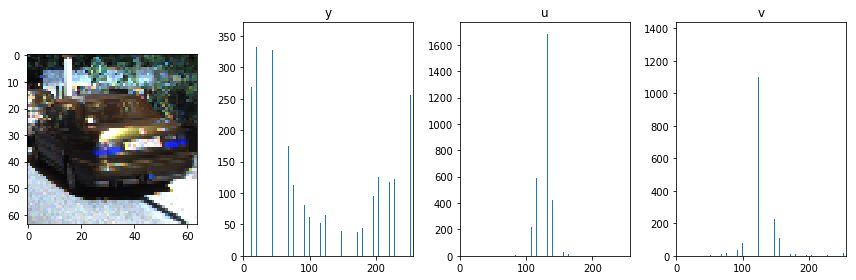

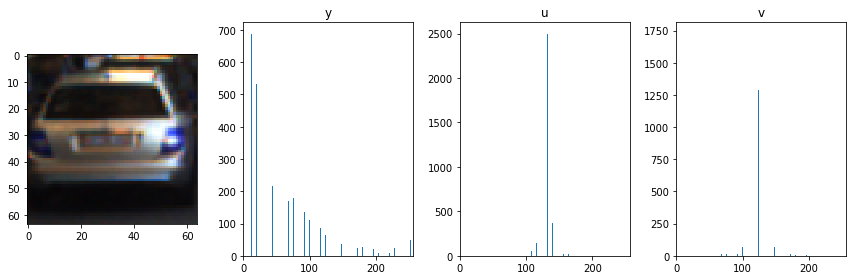

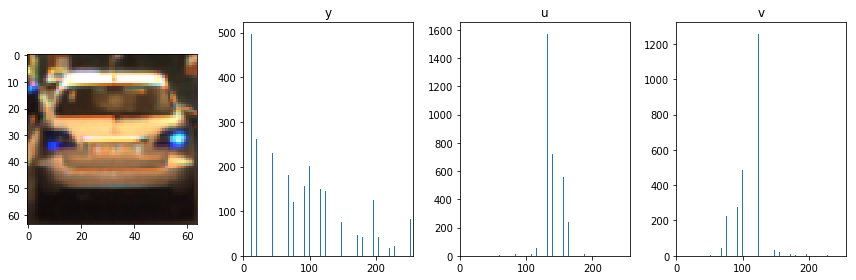

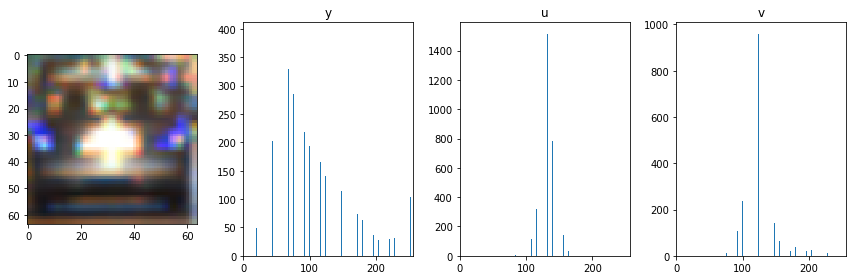

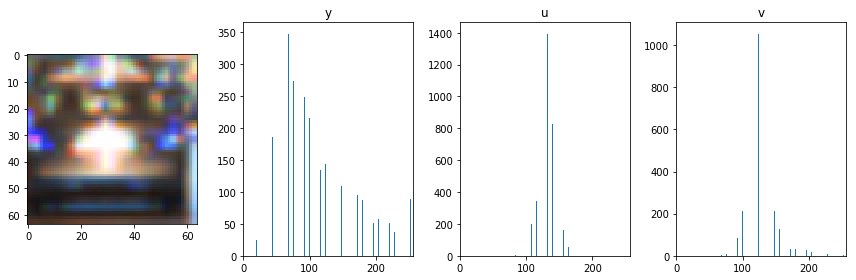

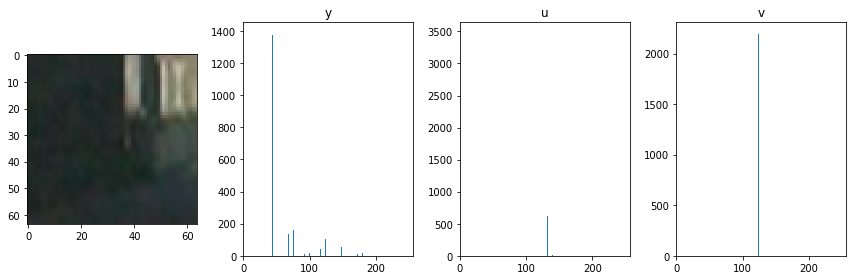

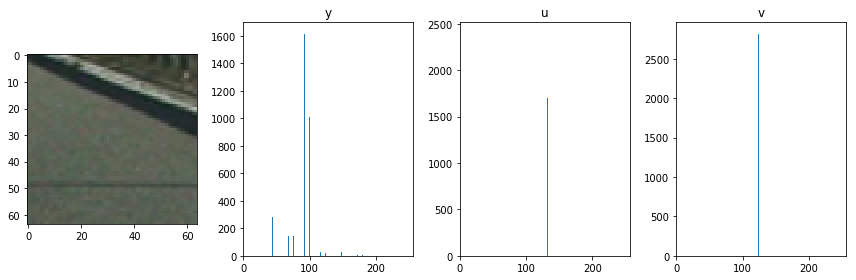

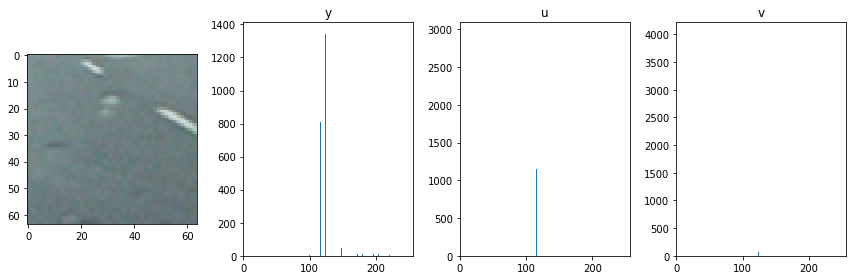

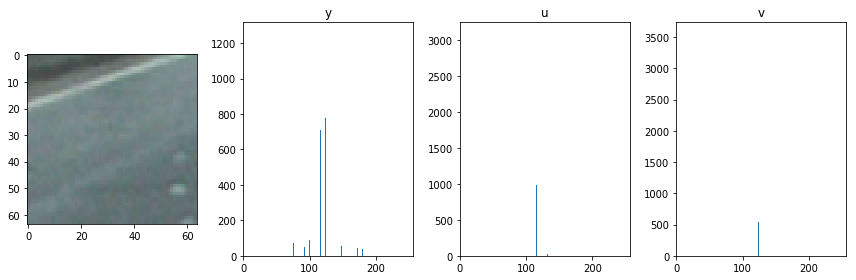

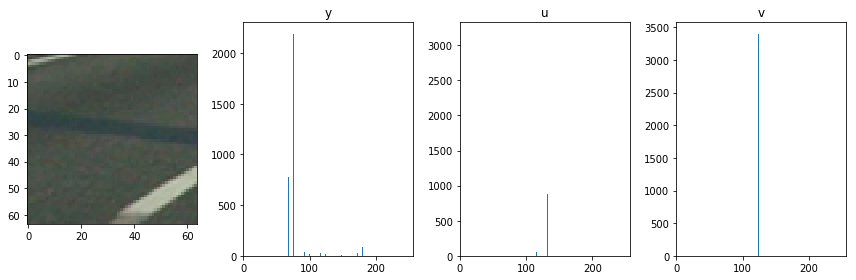

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins, bins_range):
    # Compute the histogram of the channels (1, 2, & 3) separately
    hist1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hist1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist1[0], hist2[0], hist3[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist1, hist2, hist3, bin_centers, hist_features

def display_hist(img_list,cspace): 
    for image in img_list:
        feature_image =  ConvertColorSpace(image,cspace)
        c1, c2, c3, bincen, feature_vec = color_hist(feature_image, nbins=32, bins_range=(0, 256))
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1,4,1)
        plt.imshow(image)    
        plt.subplot(1,4,2)
        plt.bar(bincen, c1[0])
        plt.xlim(0, 256)
        plt.title('y')
        plt.subplot(1,4,3)
        plt.bar(bincen, c2[0])
        plt.xlim(0, 256)
        plt.title('u')
        plt.subplot(1,4,4)
        plt.bar(bincen, c3[0])
        plt.xlim(0, 256)
        plt.title('v')
        fig.tight_layout()
        
# Test color_hist:

# get random n vehicle images
n=5
x = np.random.randint(0, vehsize-n)
images_vehicle= Vehicles [x: x+n]
images_nonvehicle = NotVehicles[x: x+n]

display_hist(images_vehicle,'YUV')
display_hist(images_nonvehicle,'YUV')

In [6]:
# Define a function to compute binned spatial features      
def bin_spatial(img, size ):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

## Classification

In [7]:
#Define a function that extracts the following three features from a list of images:
# 1) Color Histogram in RGB
# 2) Spatial Binning
# 3) HOG Feature Extraction

def extract_features(imgs, cspace_hist, cspace_bin, cspace_HOG, spatial_size,hist_bins, hist_range,orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    # Create lists to append feature vectors 
    spatial_features = []
    hist_features = []
    hog_features = np.array([])
    features = []
    for image in imgs:
        # Convert image to given color space for Histogram & HOG
        img_converted_hist = ConvertColorSpace(image,cspace_hist) 
        img_converted_bin = ConvertColorSpace(image,cspace_bin) 
        img_converted_HOG = ConvertColorSpace(image,cspace_HOG) 

        # Color Pixel Histogram Feature Vector:
        c1, c2, c3, bincen, hist_features = color_hist(img_converted_hist, hist_bins, hist_range)
        
        # Spatial Binning Feature Vector:
        spatial_features = bin_spatial(img_converted_bin,spatial_size)

        # HOG Feature Vector: 
        if hog_channel == 'ALL':
            hog_temp = []
            for channel in range(img_converted_HOG.shape[2]):
                hog_temp = get_hog_features(img_converted_HOG[:,:,channel],orient, 
                                                     pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True)

                hog_temp = np.ravel(hog_temp)
                hog_features = np.concatenate((hog_features,hog_temp))
        else:
            hog_features = get_hog_features(img_converted_HOG[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)     

        # Debugging Vector Sizes:
        #print("spatial = ", spatial_features.shape,
        #      "Hist = ",hist_features.shape,
        #      "HOG  =",hog_features.shape)
        #print(img_converted_HOG.shape)
        
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        hog_features = np.array([]) 
        
    return features

In [8]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import time

# Extract features from vehicle images:
print ("Generating feature vectors...")
print()

t=time.time()

#Color Histogram Parameters:
histbin = 32 
cspace_hist = 'YUV' 

# Spatial Binning Parameters:
spatial = 12 
cspace_bin = 'YUV'

#HOG Parameters:
cspace_HOG = 'YCrCb' 
orient = 12
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

car_features = extract_features(Vehicles, cspace_hist, cspace_bin, cspace_HOG, (spatial, spatial), histbin, (0, 256),
                               orient, pix_per_cell, cell_per_block, hog_channel)
notcar_features = extract_features(NotVehicles, cspace_hist, cspace_bin, cspace_HOG, (spatial, spatial), histbin, (0, 256),
                               orient, pix_per_cell, cell_per_block, hog_channel)
t2 = time.time()
print('Using Color Histogram\nWith ',histbin," bins, in ", cspace_hist , " color space.")
print()
print('Using Spatial Binning\nWith ',spatial," spatial size, in ", cspace_bin , " color space.")
print()
print('Using HOG parmaters:\n',cspace_HOG,'Color Space\n', hog_channel, 'HOG Channel\n',
      orient, ' orientation bins\n',pix_per_cell,
     'pixels per cell\n', cell_per_block,' cells per block')
print()

X = np.vstack((car_features, notcar_features)).astype(np.float64) # Array stack of feature vectors
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define labels vector
print ("Done!", round(t2-t, 5), 'Seconds to generate features')
print('Feature Vector Size = ' , X.shape)
print('Label Vector Size = ', y.shape)

# Split up data into randomized training(80%)and test(20%) sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Initialize classifier
print("\nTraining classifier...")
svc = svm.LinearSVC()
# Compute the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(100*svc.score(X_test, y_test), 5),"%")

Generating feature vectors...

Using Color Histogram
With  32  bins, in  YUV  color space.

Using Spatial Binning
With  12  spatial size, in  YUV  color space.

Using HOG parmaters:
 YCrCb Color Space
 ALL HOG Channel
 12  orientation bins
 16 pixels per cell
 2  cells per block

Done! 74.93356 Seconds to generate features
Feature Vector Size =  (19663, 1824)
Label Vector Size =  (19663,)

Training classifier...
4.39 Seconds to train SVC...
Test Accuracy of SVC =  98.55072 %


## Vehicle Tracking with Sliding Window Approach

### Develop Tracking Boxes

In [9]:
# Re-Define the chosen feature space parameters for the second half of the project:

#Color Histogram Parameters:
histbin = 32 
cspace_hist = 'YUV' 

# Spatial Binning Parameters:
spatial = 12 
cspace_bin = 'YUV'

#HOG Parameters:
cspace_HOG = 'YCrCb' 
orient = 12
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

In [10]:
# Helper function that draws boxes boxes on img with color and thickness
# color_choice = True for randomized colors, False for Blue.
def draw_boxes(img, bboxes, thick, color_choice ):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        if(color_choice == True):
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        else:
            color = (0,0,255)
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    

In [11]:
# The following function, adapted from the course notes, is capable of generating sliding windows 
# within a single image and then predicts the presence of vehicles based on the features within the windows.
# Returns a list of bounding boxes where vehicles were found. 
# Cell #11

def find_cars(img, cspace_hist, cspace_bin, cspace_HOG, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins,step, showAll):
    
    draw_img = np.copy(img)

    windows = [] 
    spatial_features = [] 
    hist_features = [] 
    
    # Crop  input image and convert todesired color spaces for feature extraction:
    img_tosearch = img[ystart:ystop,:,:]
    img_tosearch_RGB = ConvertColorSpace(img_tosearch,'RGB')
    ctrans_tosearch = ConvertColorSpace(img_tosearch,cspace_HOG)
    img_converted_hist = ConvertColorSpace(img_tosearch,cspace_hist) 
    img_converted_bin = ConvertColorSpace(img_tosearch,cspace_bin)     
    
    # Rescale the images based on scaling factor
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        img_converted_hist = cv2.resize(img_converted_hist, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        img_converted_bin = cv2.resize(img_converted_bin, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step         
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract and re-size image patches for feature extraction
            subimg_hist = cv2.resize(img_converted_hist[ytop:ytop+window, xleft:xleft+window], (64,64))
            subimg_bin = cv2.resize(img_converted_bin[ytop:ytop+window, xleft:xleft+window], (64,64))     
                       
            # Extract color channel histogram        
            c1, c2, c3, bincen, hist_features = color_hist(subimg_hist, hist_bins, (0,256))             

            # Extract spatial binning histogram
            spatial_features = bin_spatial(subimg_bin, spatial_size)            

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))   
            test_prediction = svc.predict(test_features)
            confidence = svc.decision_function(test_features)
            
            # Compute boxes:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            
            
            confidence_threshold = 0.5
            if(confidence > confidence_threshold): 
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #print ("Successful Prediction, confidence = ", confidence)
                 # Hard  Mining : Save images and then manually classify based on results
                #resized = cv2.resize(img_tosearch_RGB[ytop_draw:ytop_draw+win_draw, 
                #                                      xbox_left:xbox_left+win_draw], (64,64))
                #cv2.imwrite(project_path + "Dataset/HardMining/" +
                #            str(np.random.randint(0, 100000))+".jpg",cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))

            if (showAll):
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                
             


            
    return windows 

#### Develop Layers of Windows using Various Scale Factors:

In [12]:
class Layer():
    def __init__(self,scale,ystart,step):
        self.scale = scale
        self.ystart = ystart
        self.ystop = (ystart[0]+int(scale*64),ystart[1]+int(scale*64))
        self.step = step

#Dummy image:
img = cv2.imread(project_path + "test_images/" + "test4.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

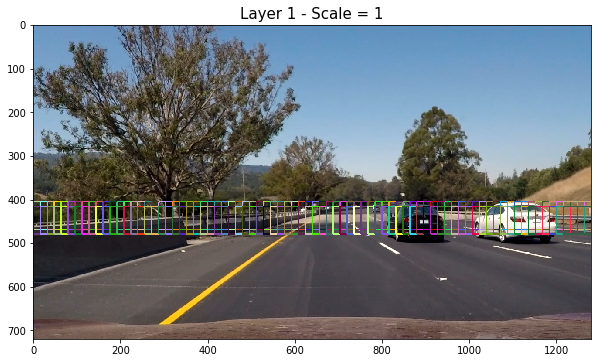

In [13]:
# Layer 1 - Smallest Windows at image center
Layer1 = []
L1 = Layer(1,(405,415),1)
boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L1.ystart[0], L1.ystop[0], L1.scale, svc, X_scaler, orient,
                 pix_per_cell, cell_per_block, (spatial,spatial), histbin, L1.step, True)
[Layer1.append(box) for box in boxes]
boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L1.ystart[1], L1.ystop[1], L1.scale, svc, X_scaler, orient,
                pix_per_cell, cell_per_block, (spatial,spatial), histbin,L1.step, True)
[Layer1.append(box) for box in boxes]

image = cv2.imread(project_path + "test_images/" + "test6.jpg")
image =  cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
test_img1 = draw_boxes(image,Layer1,2,True)
plt.figure(figsize=(10,7))
plt.imshow(test_img1)
plt.title("Layer 1 - Scale = 1", fontsize=15)


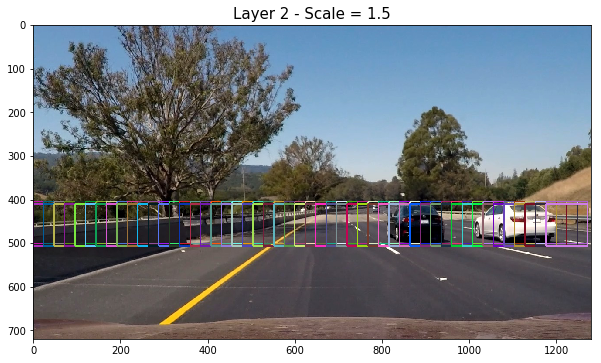

In [14]:
# Layer 2

Layer2 = []

L2 = Layer(1.5,(405,410),1)
boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L2.ystart[0], L2.ystop[0], L2.scale, svc, X_scaler, orient, pix_per_cell,
                        cell_per_block, (spatial,spatial), histbin,L2.step, True)
[Layer2.append(box) for box in boxes]
boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L2.ystart[1], L2.ystop[1], L2.scale, svc, X_scaler, orient, pix_per_cell,
                        cell_per_block, (spatial,spatial), histbin,L2.step, True)
[Layer2.append(box) for box in boxes]
image = cv2.imread(project_path + "test_images/" + "test6.jpg")
image =  cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
test_img2 = draw_boxes(image,Layer2,2,True)
plt.figure(figsize=(10,7))
plt.imshow(test_img2)
plt.title("Layer 2 - Scale = 1.5", fontsize=15)

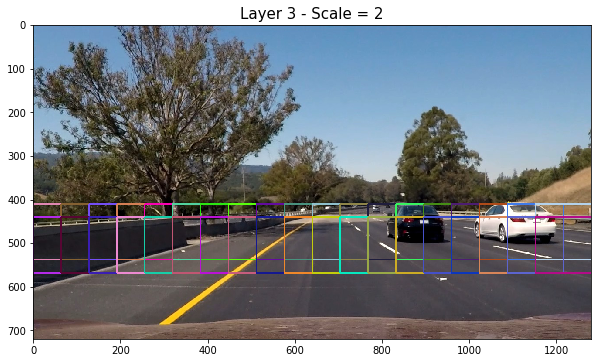

In [15]:
# Layer 3
Layer3 = []

L3 = Layer(2,(410,440),2)

boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L3.ystart[0], L3.ystop[0], L3.scale, svc, X_scaler, orient,
                 pix_per_cell,cell_per_block, (spatial,spatial), histbin,L3.step, True)
[Layer3.append(box) for box in boxes]

boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L3.ystart[1], L3.ystop[1], L3.scale, svc, X_scaler, orient,
                 pix_per_cell,cell_per_block, (spatial,spatial), histbin,L3.step, True)
[Layer3.append(box) for box in boxes]

image = cv2.imread(project_path + "test_images/" + "test6.jpg")
image =  cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
test_img3 = draw_boxes(image,Layer3,2,True)
plt.figure(figsize=(10,7))
plt.imshow(test_img3)
plt.title("Layer 3 - Scale = 2", fontsize=15)


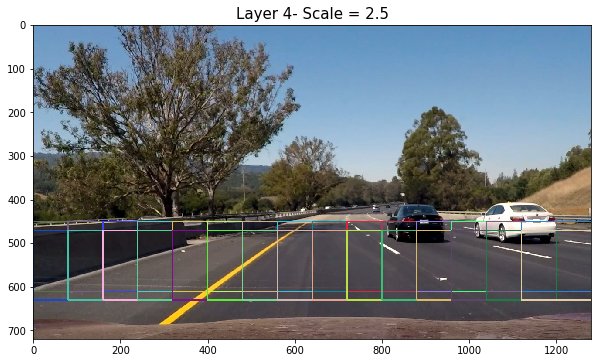

In [16]:
# Layer 4

Layer4 = []

L4 = Layer(2.5,(450,470),2)

boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L4.ystart[0], L4.ystop[0], L4.scale, svc, X_scaler, orient,
                 pix_per_cell,  cell_per_block, (spatial,spatial), histbin,L4.step, True)
[Layer4.append(box) for box in boxes]

boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L4.ystart[1], L4.ystop[1], L4.scale, svc, X_scaler, orient, 
                 pix_per_cell,  cell_per_block, (spatial,spatial), histbin,L4.step, True)
[Layer4.append(box) for box in boxes]
image = cv2.imread(project_path + "test_images/" + "test6.jpg")
image =  cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
test_img4 = draw_boxes(image,Layer4,2,True)
plt.figure(figsize=(10,7))
plt.imshow(test_img4)
plt.title("Layer 4- Scale = 2.5", fontsize=15)


In [17]:
TotalBoxes = len(Layer1)+len(Layer2)+len(Layer3)+len(Layer4)
print('In Total there are ' ,TotalBoxes, ' windows to search.')

In Total there are  367  windows to search.


### Search All Boxes for Vehicles

In [18]:
# The following function takes an image and runs all windows through the classifier to identify vehicles.
# A list of windows where vehicles have been detected is returned.

def run_search(img):
    Windows_List = []    

    #Layer 1
    boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L1.ystart[0], L1.ystop[0], L1.scale, svc, X_scaler, orient,
                     pix_per_cell,cell_per_block, (spatial,spatial), histbin,L1.step, False)
    [Windows_List.append(box) for box in boxes]
    boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L1.ystart[1], L1.ystop[1], L1.scale, svc, X_scaler, orient,
                     pix_per_cell, cell_per_block, (spatial,spatial), histbin,L1.step, False)
    [Windows_List.append(box) for box in boxes]

    #Layer 2:
    boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L2.ystart[0], L2.ystop[0], L2.scale, svc, X_scaler, orient,
                     pix_per_cell,cell_per_block, (spatial,spatial), histbin, L2.step,False)
    [Windows_List.append(box) for box in boxes]
    boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L2.ystart[1], L2.ystop[1], L2.scale, svc, X_scaler, orient,
                     pix_per_cell,cell_per_block, (spatial,spatial), histbin,L2.step, False)
    [Windows_List.append(box) for box in boxes]
    
    #Layer 3:
    boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L3.ystart[0], L3.ystop[0], L3.scale, svc, X_scaler, orient,
                     pix_per_cell,cell_per_block, (spatial,spatial), histbin,L3.step, False)
    [Windows_List.append(box) for box in boxes]

    boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L3.ystart[1], L3.ystop[1], L3.scale, svc, X_scaler, orient,
                     pix_per_cell,cell_per_block, (spatial,spatial), histbin,L3.step, False)
    [Windows_List.append(box) for box in boxes]
    
    #Layer 4:
    boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L4.ystart[0], L4.ystop[0], L4.scale, svc, X_scaler, orient,
                     pix_per_cell,  cell_per_block, (spatial,spatial), histbin,L4.step, False)
    [Windows_List.append(box) for box in boxes]

    boxes= find_cars(img, cspace_hist, cspace_bin, cspace_HOG, L4.ystart[1], L4.ystop[1], L4.scale, svc, X_scaler, orient, 
                     pix_per_cell,  cell_per_block, (spatial,spatial), histbin,L4.step, False)
    [Windows_List.append(box) for box in boxes]

    return Windows_List

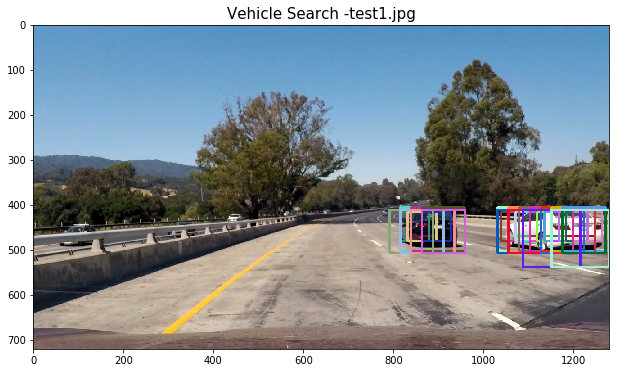

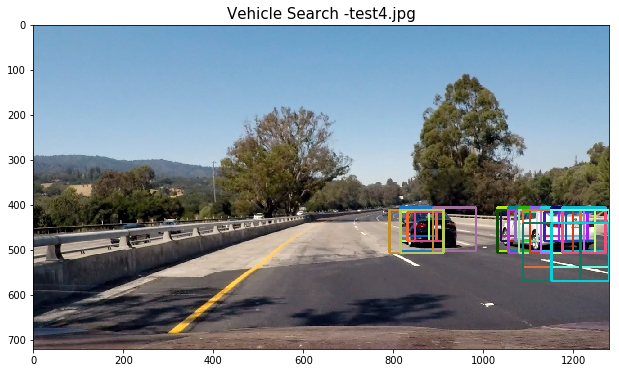

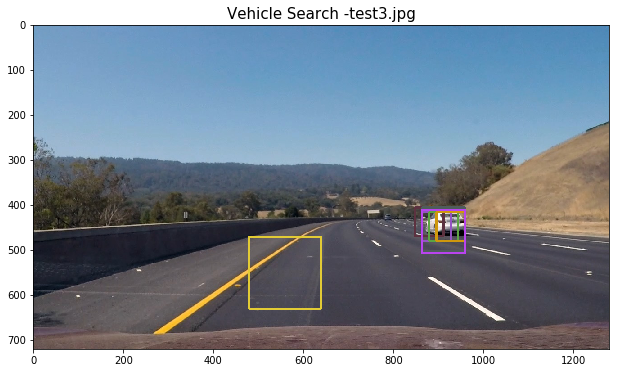

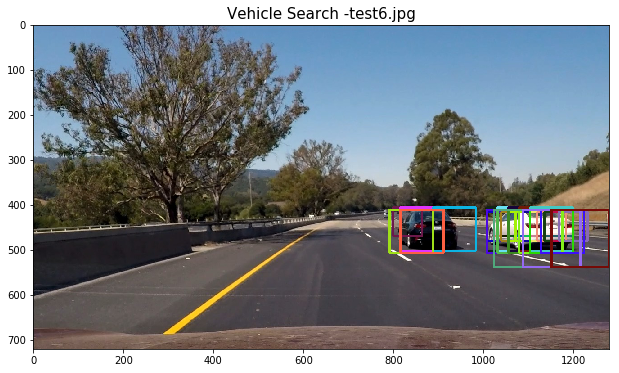

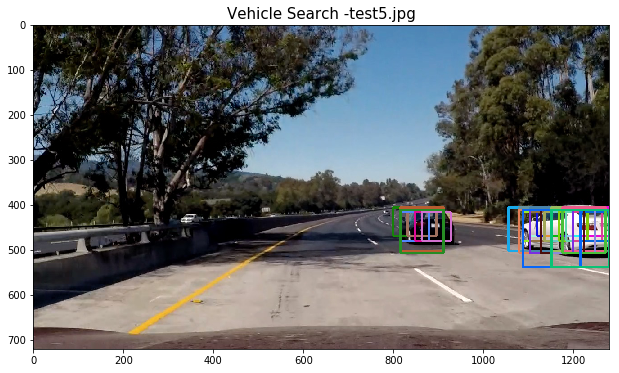

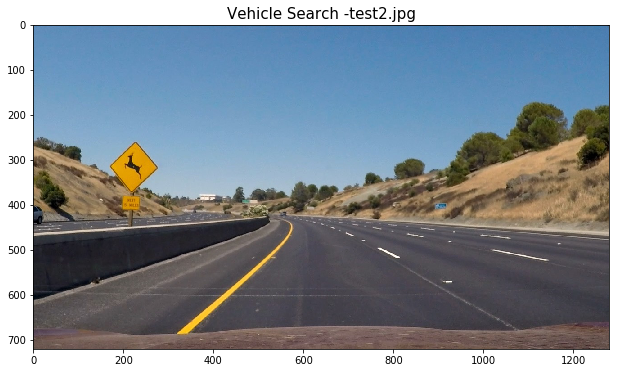

In [19]:
#Test the classifier pipeline on test_images folder

test_images = glob.glob(project_path + "test_images/*.jpg")
#test_images = glob.glob(project_path + "Dataset/mining/*.png")
for fname in test_images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    
    Window_Search = run_search(test_img)

    return_img = draw_boxes(test_img,Window_Search,3,True)
    f, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(return_img)
    ax1.set_title('Vehicle Search -' + fname.split('/')[-1], fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### False Positive Filtering

In [20]:
# Helper function to draw boxes on images that have been labelled with 
# the label() from from scipy.ndimage.measurements.
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        boxes.append(bbox)
    # Return the image
    return img,boxes


In [21]:
# This function, taken from the course notes, generates a heat map over a blank image
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

# This function, taken  from the course note, filters out the heatmap based on the threshold.
# All values less than or equal to the threshold will be set to zero
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

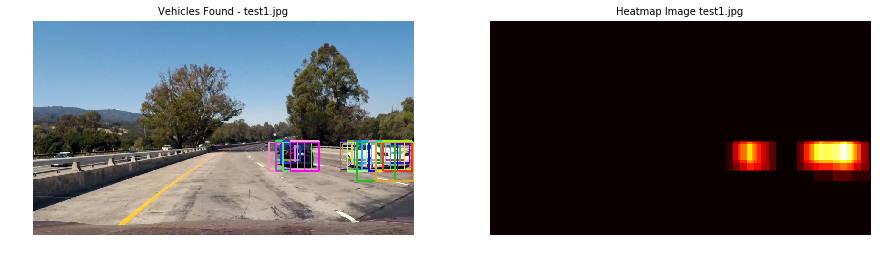

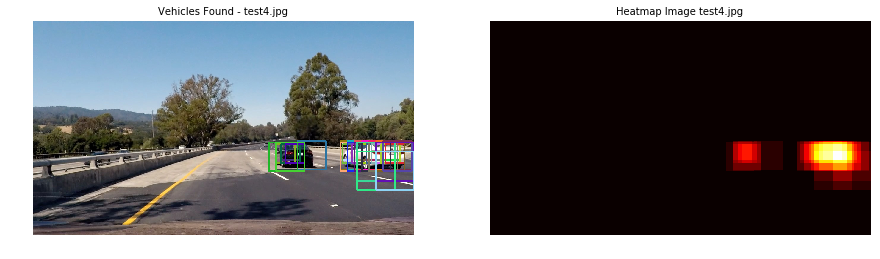

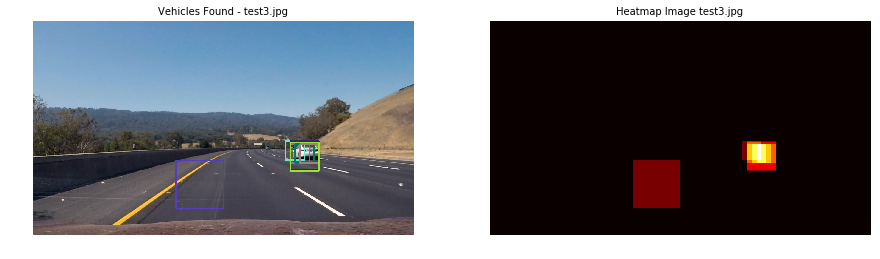

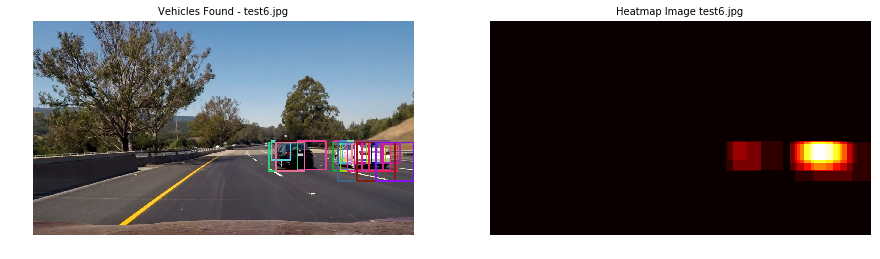

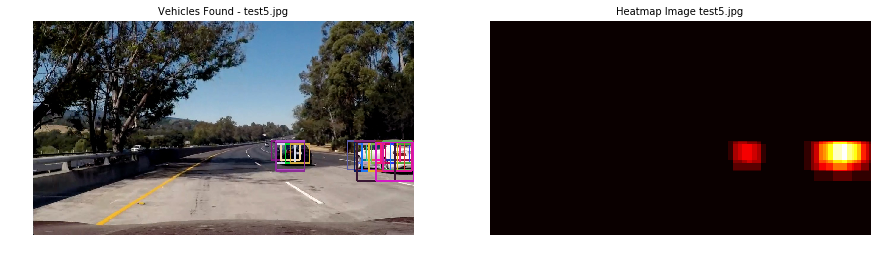

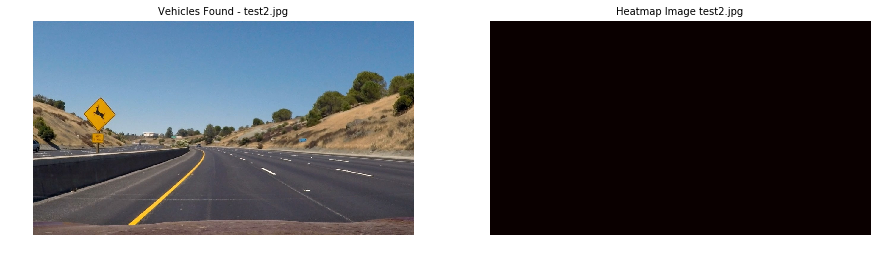

In [22]:
from scipy.ndimage.measurements import label

# Use heatmapping to eliminate false positives.
test_images = glob.glob(project_path + "test_images/test*.jpg")

for fname in test_images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    found_windows = run_search(test_img) #search for vehicles
    
    zeros_heatmap = np.zeros_like(test_img[:,:,0])
    heatmap_img = add_heat(zeros_heatmap, found_windows)    
    f, (ax1, ax2 ) = plt.subplots(1,2, figsize=(15, 10))
    ax1.imshow(draw_boxes(test_img,found_windows,3,True))
    ax1.set_title('Vehicles Found - ' + fname.split('/')[-1], fontsize=10)
    ax1.xaxis.label.set_visible(False)
    ax1.axis('off')
    ax2.imshow(heatmap_img , cmap = 'hot')
    ax2.set_title('Heatmap Image ' + fname.split('/')[-1], fontsize=10)
    ax2.axis('off')    


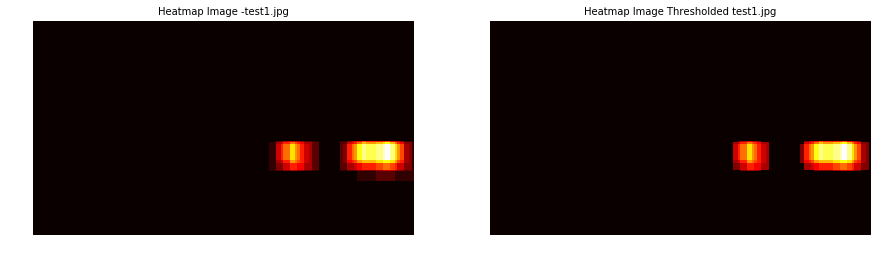

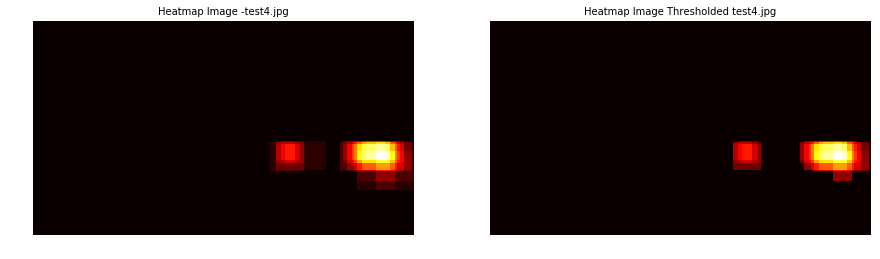

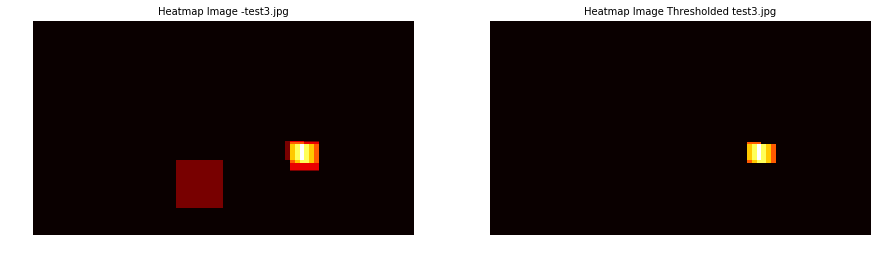

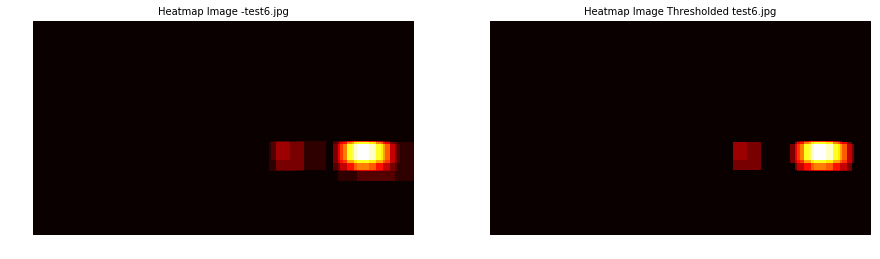

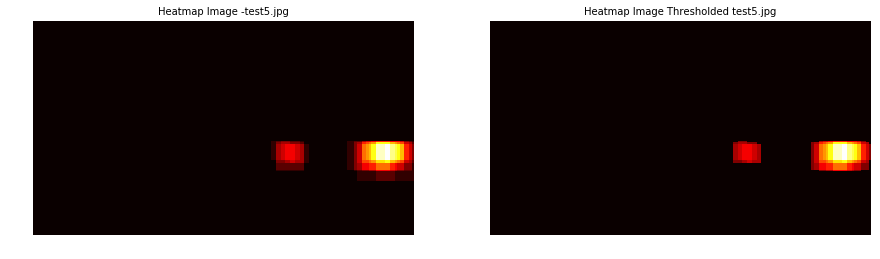

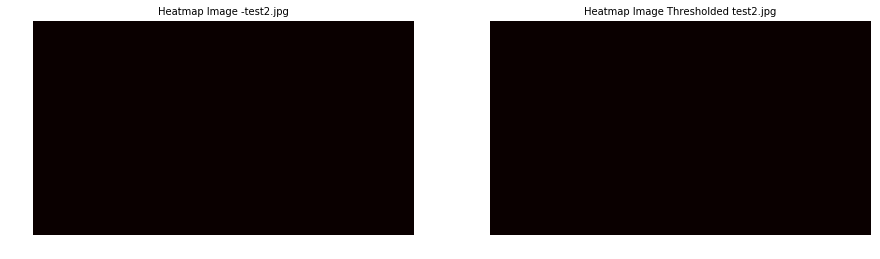

In [23]:
#Threshold and organize the heatmap groupings with label():

test_images = glob.glob(project_path + "test_images/test*.jpg")
for fname in test_images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    found_windows = run_search(test_img) #search for vehicles
    
    zeros_heatmap = np.zeros_like(test_img[:,:,0])
    heatmap_img = add_heat(zeros_heatmap, found_windows)
    heatmap_img_thresh  = apply_threshold(np.copy(heatmap_img),2)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
    ax1.imshow(heatmap_img,cmap = 'hot')
    ax1.set_title('Heatmap Image -' + fname.split('/')[-1], fontsize=10)
    ax1.xaxis.label.set_visible(False)
    ax1.axis('off')
    ax2.imshow(heatmap_img_thresh , cmap = 'hot')
    ax2.set_title('Heatmap Image Thresholded '  + fname.split('/')[-1], fontsize=10)
    ax2.axis('off')    


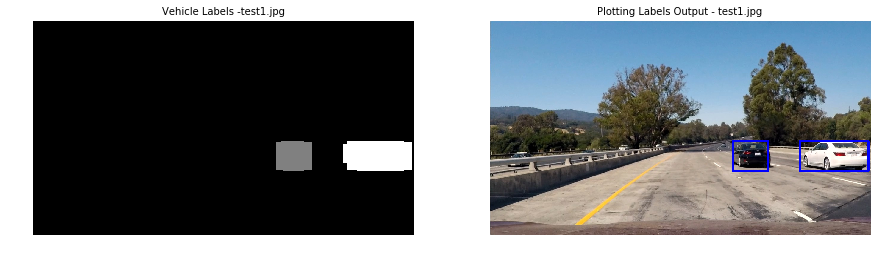

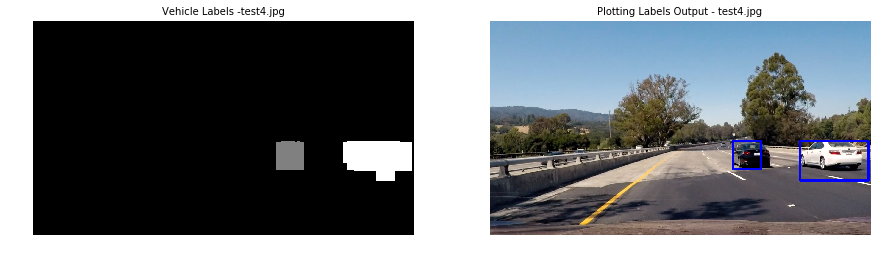

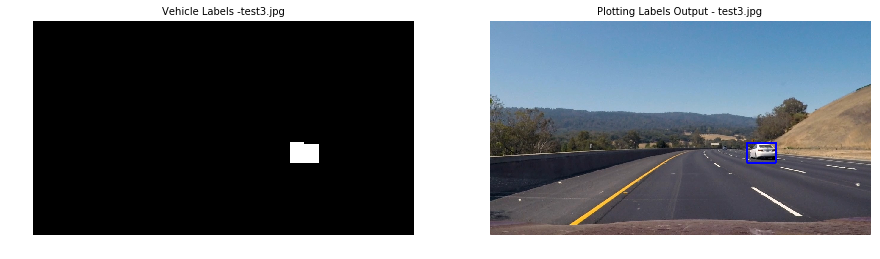

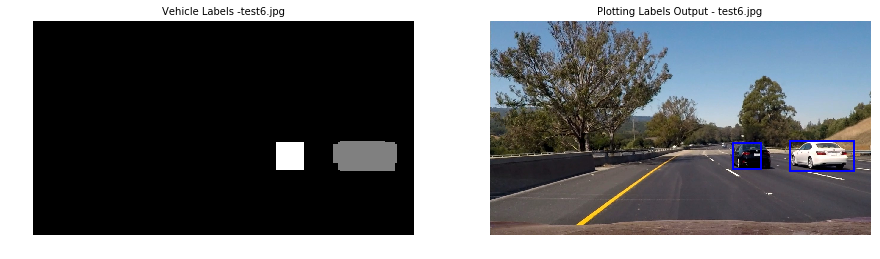

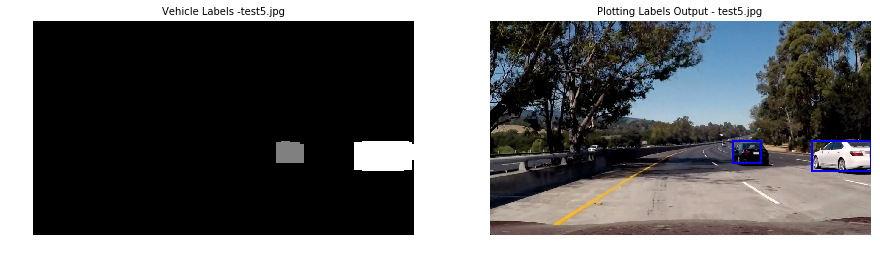

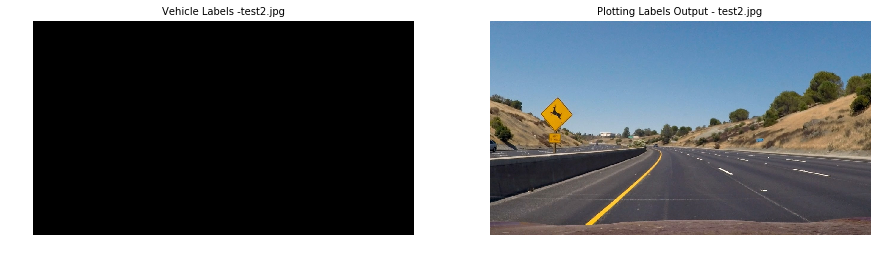

In [24]:
#Threhold and label the heatmap:

# Use heatmapping to eliminate false positives.
test_images = glob.glob(project_path + "test_images/test*.jpg")
for fname in test_images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    found_windows = run_search(test_img) #search for vehicles
    
    zeros_heatmap = np.zeros_like(test_img[:,:,0])
    heatmap_img = add_heat(zeros_heatmap, found_windows)
    heatmap_img_thresh  = apply_threshold(np.copy(heatmap_img),2)
    labels = label(heatmap_img_thresh)
    heatmap_img_thresh_label,bboxes = draw_labeled_bboxes(np.copy(test_img), labels)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
    #f.subplots_adjust(hspace = .001, wspace=.001
    #f.tight_layout()
    ax1.imshow(labels[0],cmap = 'gray')
    ax1.set_title('Vehicle Labels -' + fname.split('/')[-1], fontsize=10)
    ax1.xaxis.label.set_visible(False)
    ax1.axis('off')
    ax2.imshow(heatmap_img_thresh_label , cmap = 'hot')
    ax2.set_title('Plotting Labels Output - '  + fname.split('/')[-1], fontsize=10)
    ax2.axis('off')    

### Wrapping up

In [25]:
# This class will keep track of vehicle boxes across video frames
# Constructor instance variable threshold represents the number of video frames to store in history
class Vehicle_Tracker():
    def __init__(self,threshold):
        self.WindowHistory = []
        self.threshold = threshold
        
    #Function that adds a list of windows for a new frame
    def addWindows(self,windows):
        self.WindowHistory.append(windows)
        
        # If the list is getting too big, get rid of oldest frame ( first in list )
        if(len(self.WindowHistory) > self.threshold):
            self.WindowHistory = self.WindowHistory[1:]
        
    
    

In [26]:
from scipy.ndimage.measurements import label
import math

n = 40 
Tracker = Vehicle_Tracker(n) # Create tracker, store last n frames

# This function summarizes the entire pipeline to be used in the video processing
def process_image(img):

    # Search for vehicles using sliding window approach
    boxes = run_search(img)
    
    #Apply heatmapping pipeline
    zeros_heatmap = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(zeros_heatmap, boxes)
    heatmap_img_thresh  = apply_threshold(np.copy(heatmap_img),2) 
    labels = label(heatmap_img_thresh)
    heatmap_img_thresh_label,bboxes = draw_labeled_bboxes(np.copy(img), labels)

    # Add newly found vehicles to tracker 
    Tracker.addWindows(bboxes)
    
    #Now apply similar pipeline for vehicle frame history    
    #Go through previous n frames, stack the heatmaps 
    heatmap_img_tracker = np.zeros_like(img[:,:,0])
    for windows in Tracker.WindowHistory:
        heatmap_img_tracker = add_heat(heatmap_img_tracker, windows)
    
    # Apply threshold on heatmap images to filter false positives:
    heatmap_threshold_tracker = 20
    heatmap_img_thresh_tracker = apply_threshold(np.copy(heatmap_img_tracker),heatmap_threshold_tracker)
    labels = label(heatmap_img_thresh_tracker)
    output,x = draw_labeled_bboxes(np.copy(img), labels)    

    return output

In [27]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
    
output_video = "output_video.mp4"
test_video = "project_video.mp4"
    
#clip1 = VideoFileClip(test_video).subclip(35,50)
#clip1.save_frame('./Dataset/mining/8.png', t=8) #Save images
clip1 = VideoFileClip(test_video)
process_clip = clip1.fl_image(process_image)
process_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [11:06<00:00,  1.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 



### Code Graveyard

In [ ]:
import math

#Generate 4 layers of box sizes to be used in sliding window approach:

# Only look at the bottom half (pixels 400 onward) of the image where vehicles are present
def slide_window(img):
    windows = []
   
    img_height = img.shape[0]
    img_width = img.shape[1]    
    print(img_height,img_width)

    #Layer 1:
    xlimit = [50,img_width] # Define boundary limits in x
    ylimit = [np.int(400),650] # Define boundary limits in y
    xy_window = (200,200)
    xy_overlap = (0.5,0.75)    
    windows1 = window_generator(xlimit,ylimit,xy_window,xy_overlap)
    for box in windows1:
        windows.append(box)
        
    #Layer 2:
    xlimit = [30,img_width] # Define boundary limits in x
    ylimit = [np.int(400),550] # Define boundary limits in y
    xy_window = (130,130)
    xy_overlap = (0.5,0.85)    
    windows2 = window_generator(xlimit,ylimit,xy_window,xy_overlap)
    for box in windows2:
        windows.append(box)
    

    #layer 3:
    xlimit = [50,img_width] # Define boundary limits in x
    ylimit = [400,550] # Define boundary limits in y
    xy_window = (100,100)
    xy_overlap = (0.5,0.75)   
    windows3= window_generator(xlimit,ylimit,xy_window,xy_overlap)    
    for box in windows3:
        windows.append(box)
    
    #Layer 4:
    xlimit = [0,img_width] # Define boundary limits in x
    ylimit = [np.int(400),500] # Define boundary limits in y
    xy_window = (60,60)
    xy_overlap = (0.75,0.5)    
    windows4 = window_generator(xlimit,ylimit,xy_window,xy_overlap)
    for box in windows4:
        windows.append(box)
        

    
    print("Total Number of Boxes = ", len(windows))
    return windows

# Displaying the boxes on a test image:

image_window = cv2.imread(project_path + "test_images/" + "test4.jpg")
image_window = cv2.cvtColor(image_window,cv2.COLOR_BGR2RGB)

img_height = image_window.shape[0]
img_width = image_window.shape[1]

windows = slide_window(image_window)

window_img = draw_boxes(image_window, windows,True, 4)
plt.figure(figsize=(10,10))
plt.imshow(window_img)
cv2.imwrite("ReportImagesx/Layer2_Boxes.png",cv2.cvtColor(window_img,cv2.COLOR_RGB2BGR))

In [ ]:
#This function takes an image and returns the same image with superimposed boxes over identified vehicles
#Input image must be in RGB format
def car_search(image,svc,search_windows):
    
    #Color Histogram Parameters:
    histbin = 64 # Number of Histogram Bins for Color Histogram Feature Vector (3 x 32 = 96 elements)

    # Spatial Binning Parameters:
    spatial = 12 # Resize Dimension for spatial binning
    cspace_hist = 'RGB' # Color Space for histogram 

    #HOG Parameters:
    cspace_HOG = 'YUV' #can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 12
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"    
    
    found_boxes = [] #list to store boxes where vehicles are found      
    
    for box in search_windows:
        #Extract rectangular box from image to search
        extract_img = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        resized_img = [cv2.resize(extract_img,(64, 64))] #Resize image as list with numpy array
        
        #Use Trained model to predict whether a vehicle present in box
        car_features = extract_features(resized_img, cspace_hist, cspace_HOG, (spatial, spatial),
                                        histbin, (0, 256),orient, pix_per_cell, cell_per_block, hog_channel)
        
        
        #Scaled_Features = X_scaler.transform(car_features)
        Scaled_Features = X_scaler.transform(np.array(car_features).reshape(1, -1))
        predict = svc.predict(Scaled_Features)
        if( predict == 1 ):
            found_boxes.append(box)
    vehicles_img = draw_boxes(image, found_boxes,False, 3)

    return vehicles_img,found_boxes
    
    
# Test out Car Search 
test_images = glob.glob(project_path + "test_images/test*.jpg")
for fname in test_images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    
    ScanImage = car_search(test_img,svc,windows)
    return_img = ScanImage[0]

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    f.tight_layout()
    ax1.imshow(test_img)
    ax1.set_title('Original Image -' + fname.split('\\')[-1], fontsize=15)
    ax2.imshow(return_img)
    ax2.set_title('Found Vehicles', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    

In [ ]:
# This function, taken from the notes, generates boxes based on limit in x and y, size of each box, and x-y overlap.
def window_generator(xlimit,ylimit,xy_window,xy_overlap):
    boxes = []
    xspan = xlimit[1] - xlimit[0]
    yspan = ylimit[1] - ylimit[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + xlimit[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + ylimit[0]
            endy = starty + xy_window[1]
            # Append window position to list
            boxes.append(((startx, starty), (endx, endy)))
    return boxes